# Step 2. Data Preparation

---

This step includes both data cleaning and data processing. The resulting data will be saved into `./data/processed/` folder under the same class-separated folder structure as the raw dataset. The steps are as follows:

1. Augment Identical Images (Data Duplication). Method: Comparing `imagehash.average_hash()` of each image to get the identical images, then randomly rotate and flip them.
2. Remove Transparency and Grayscale: Convert images of all other modes to `RGB`, excluding `L` images (grayscale).
3. Standardize Sizes and Aspect Ratios: **512x512** pixels, 1:1 aspect ratio.
4. Normalize Pixel Values: common scale: [0, 1].
5. Quality Control: Manual inspection of a subset of images to ensure overall dataset quality.

In [1]:
# Imports and environmental setups

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import imagehash
from PIL import Image


# Custom utils functions
from utils import dataset
from utils.visualization import data_countplot
from utils.visualization import data_histplot
from utils.visualization import data_plot_16samples


plt.style.use('ggplot')
path_raw_dataset = '../data/raw/'
path_processed_dataset = '../data/processed/'

## Load Raw Dataset

Using our custom `dataset.load()` function.

In [2]:
df_raw = dataset.load('../data/raw')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16362 entries, 0 to 16361
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       16362 non-null  object 
 1   FileType      16362 non-null  object 
 2   Width         16362 non-null  int64  
 3   Height        16362 non-null  int64  
 4   Ratio         16362 non-null  float64
 5   Mode          16362 non-null  object 
 6   Bands         16362 non-null  object 
 7   Transparency  16362 non-null  bool   
 8   Animated      16362 non-null  bool   
 9   Class         16362 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 1.0+ MB


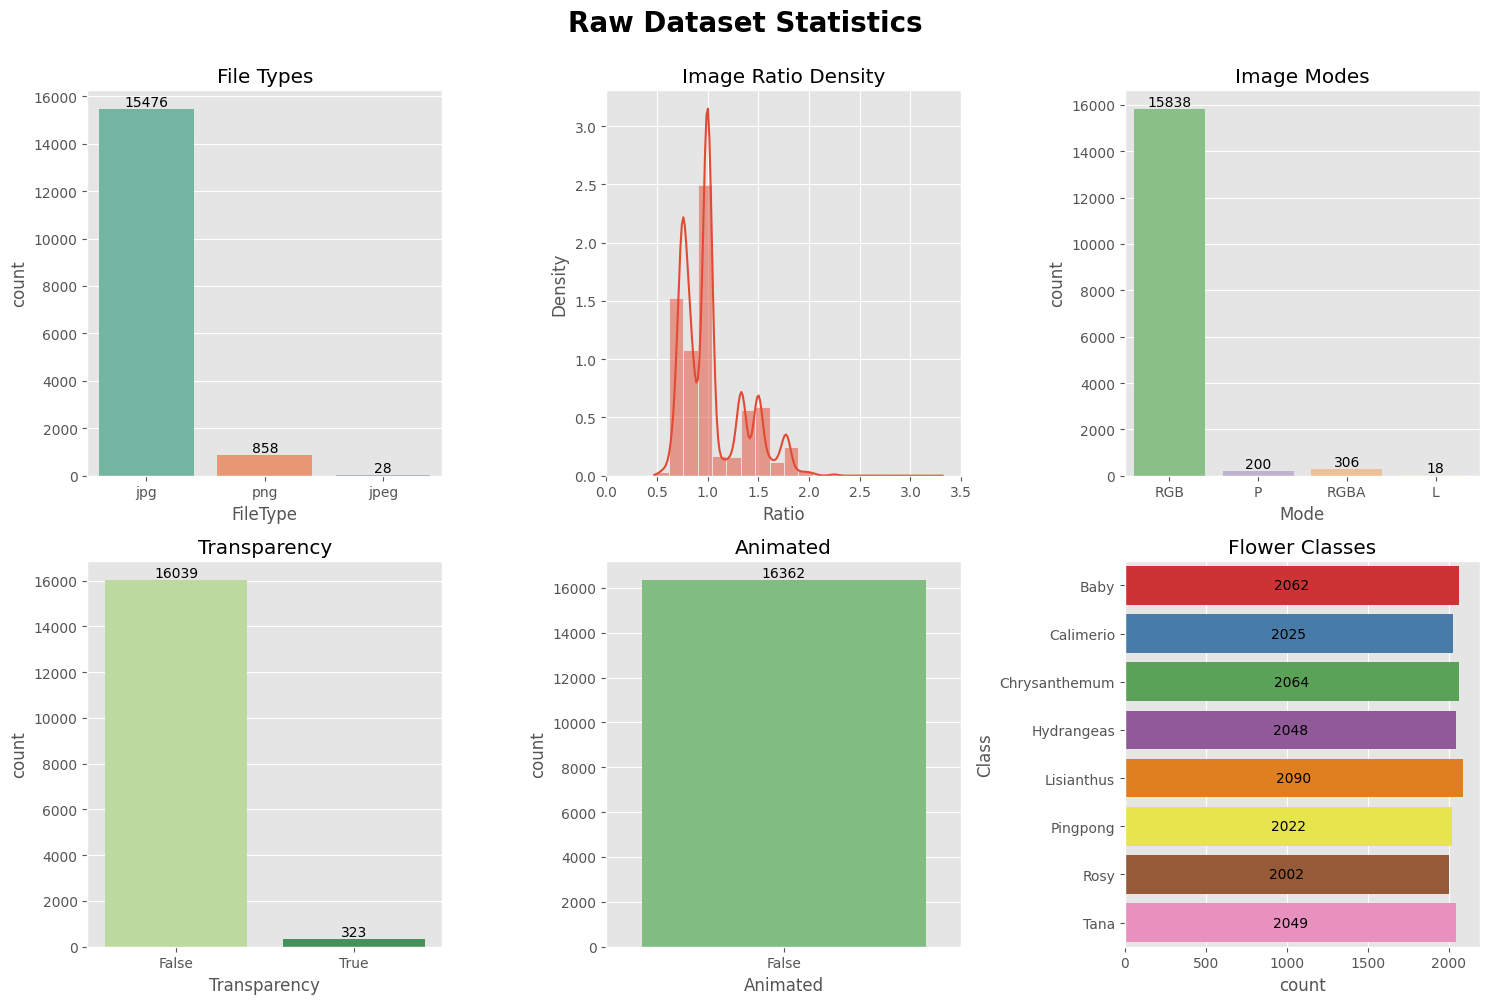

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

data_countplot(df_raw, 'FileType', ax=ax[0][0], title='File Types', annotate=True, palette='Set2')
data_histplot(df_raw, 'Ratio', ax=ax[0][1], title='Image Ratio Density', bins=20, kde=True, stat='density')
data_countplot(df_raw, 'Mode', ax=ax[0][2], title='Image Modes', annotate=True, palette='Accent')
data_countplot(df_raw, 'Transparency', ax=ax[1][0], title='Transparency', annotate=True, palette='YlGn')
data_countplot(df_raw, 'Animated', ax=ax[1][1], title='Animated', annotate=True, palette='YlGn')
data_countplot(df_raw, 'Class', ax=ax[1][2], horizontal=True, title='Flower Classes', xticklabels_rotation=45, annotate=True, palette='Set1')

fig.suptitle('Raw Dataset Statistics', fontsize=20, fontweight='bold', y=1.0)
fig.tight_layout()

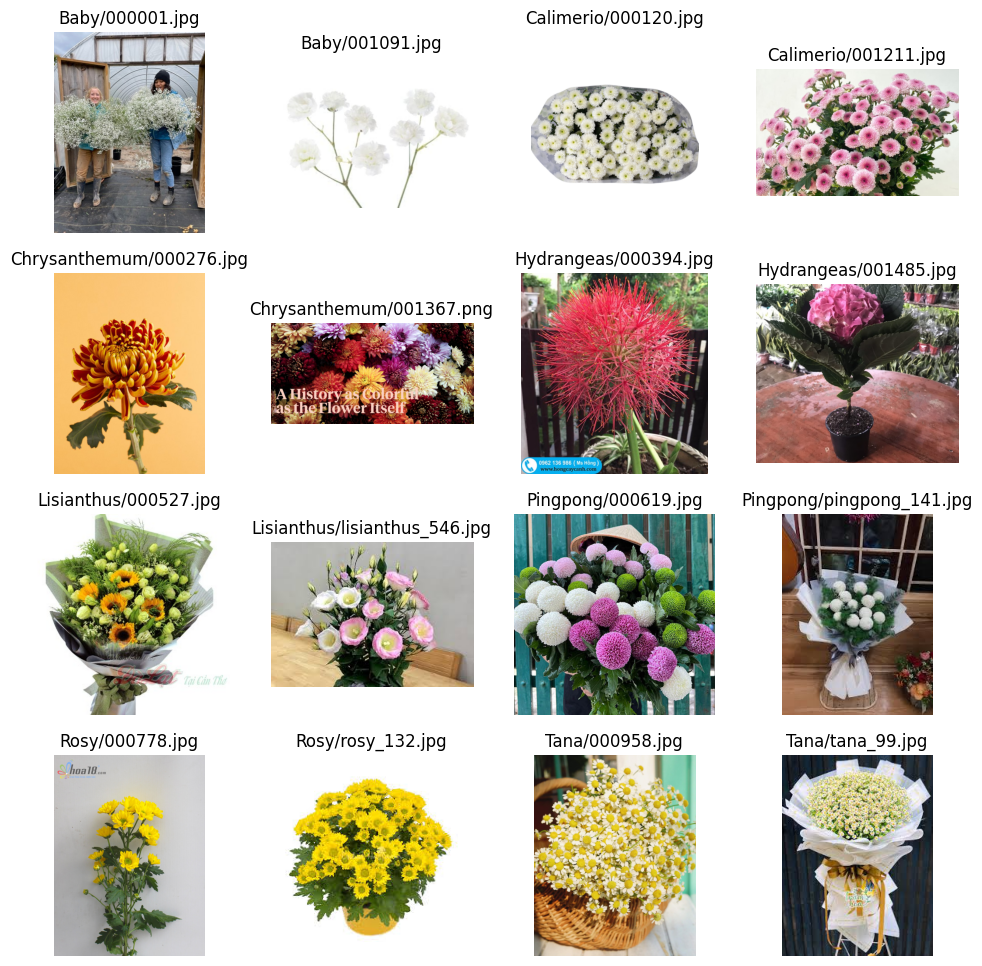

In [4]:
data_plot_16samples('../data/raw/', df_raw)

## 2.1. Data Cleaning and Processing

### 2.1.1. Identical Images (Duplicated Data) Cleaning

We are detecting all identical images and store them in a list `skipped_duplicated_images` (keeping the first copy) so that we can skip cleaning and processing and saving them into our processed dataset in `../data/processed/`:

In [5]:
image_hashes = {}
for i, row in df_raw.iterrows():
    with Image.open(f'../data/raw/{row["ImgPath"]}') as im:
        image_hash = imagehash.average_hash(im, hash_size=8)
        if image_hash in image_hashes:
            image_hashes[image_hash].append(row["ImgPath"])
        else:
            image_hashes[image_hash] = [row["ImgPath"]]

duplicated_image_hashes = {hash_val: paths for hash_val, paths in image_hashes.items() if len(paths) > 1}  # Remove hashes with a single path

duplicated_images_paths = []
for paths in duplicated_image_hashes.values():
    for i, path in enumerate(paths):
        if i > 0:  # Keeping the first copy
            duplicated_images_paths.append(path)

C:\Users\vomin\Projects\rmit\cosc2753\rmit2023a-cosc2753-assignment2\venv\Lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Number of skipped duplicated images: 11676


In [17]:
print(f'Number of duplicated images: {len(duplicated_images_paths)}')

Number of duplicated images: 11676


### 2.1.3. Further Cleaning and Processing

- Augment Identical Images
- Remove Transparency and Grayscale
- Standardize Sizes and Aspect Ratios
- Normalize Pixel Values

In [6]:
COMMON_DIM = 512  # Target common dimension (width and height for all processed images)

In [7]:
def augment(image: Image, seed: int = None) -> Image:
    if seed is not None:
        random.seed(seed)

    # Rotation
    rotation_angle = random.randint(-180, 180)
    rotated_image = image.rotate(rotation_angle, expand=False)

    # Horizontal flipping
    flip_prob = random.random()
    if flip_prob < 0.5:
        flipped_image = rotated_image.transpose(Image.FLIP_LEFT_RIGHT)
    else:
        flipped_image = rotated_image

    # Vertical flipping
    flip_prob = random.random()
    if flip_prob < 0.5:
        flipped_image = flipped_image.transpose(Image.FLIP_TOP_BOTTOM)

    return flipped_image

In [8]:
def remove_transparency(image: Image) -> Image:
    if im.mode in ('RGBA', 'RGBa', 'LA', 'La', 'PA', 'P'):
        if image.mode != 'RGBA':
            image = image.convert('RGBA')
        image = image.convert('RGB')
    return image

In [9]:
def resize_crop(image: Image, width: int, height: int) -> Image:
    original_aspect_ratio = image.width / image.height
    target_aspect_ratio = width / height

    if original_aspect_ratio > target_aspect_ratio:
        # Crop horizontally
        new_width = int(image.height * target_aspect_ratio)
        left = (image.width - new_width) // 2
        right = left + new_width
        top = 0
        bottom = image.height
    else:
        # Crop vertically
        new_height = int(image.width / target_aspect_ratio)
        top = (image.height - new_height) // 2
        bottom = top + new_height
        left = 0
        right = image.width

    cropped_image = image.crop((left, top, right, bottom))
    resized_image = cropped_image.resize((width, height), Image.Resampling.LANCZOS)

    return resized_image

In [10]:
def normalize_pixels(image: Image) -> Image:
    image_array = np.array(image)
    normalized_image_array = image_array / 255.0  # Normalize pixel values to the range [0, 1]
    return Image.fromarray((normalized_image_array * 255).astype(np.uint8))

In [11]:
for i, row in df_raw.iterrows():
    if not os.path.exists(f'{path_processed_dataset}{row["Class"]}'):
        os.makedirs(f'{path_processed_dataset}{row["Class"]}')

    img_path = row['ImgPath']
    new_img_path = ''.join(img_path.split('.')[0:-1]) + '.jpg'
    with Image.open(f'{path_raw_dataset}{img_path}') as im:
        if im.mode == 'L':
            continue  # Ignoring grayscale images

        if img_path in duplicated_images_paths:
            im = augment(im, seed=42)
        im = remove_transparency(im)
        im = resize_crop(im, COMMON_DIM, COMMON_DIM)
        im = normalize_pixels(im)

        im.save(f'{path_processed_dataset}{new_img_path}')

## 2.2. Quality Control

In [12]:
df_processed = dataset.load('../data/processed')

In [13]:
df_processed.describe()

,Width,Height,Ratio
count,16344.0,16344.0,16344.0
mean,512.0,512.0,1.0
std,0.0,0.0,0.0
min,512.0,512.0,1.0
25%,512.0,512.0,1.0
50%,512.0,512.0,1.0
75%,512.0,512.0,1.0
max,512.0,512.0,1.0


In [14]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16344 entries, 0 to 16343
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       16344 non-null  object 
 1   FileType      16344 non-null  object 
 2   Width         16344 non-null  int64  
 3   Height        16344 non-null  int64  
 4   Ratio         16344 non-null  float64
 5   Mode          16344 non-null  object 
 6   Bands         16344 non-null  object 
 7   Transparency  16344 non-null  bool   
 8   Animated      16344 non-null  bool   
 9   Class         16344 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 1.0+ MB


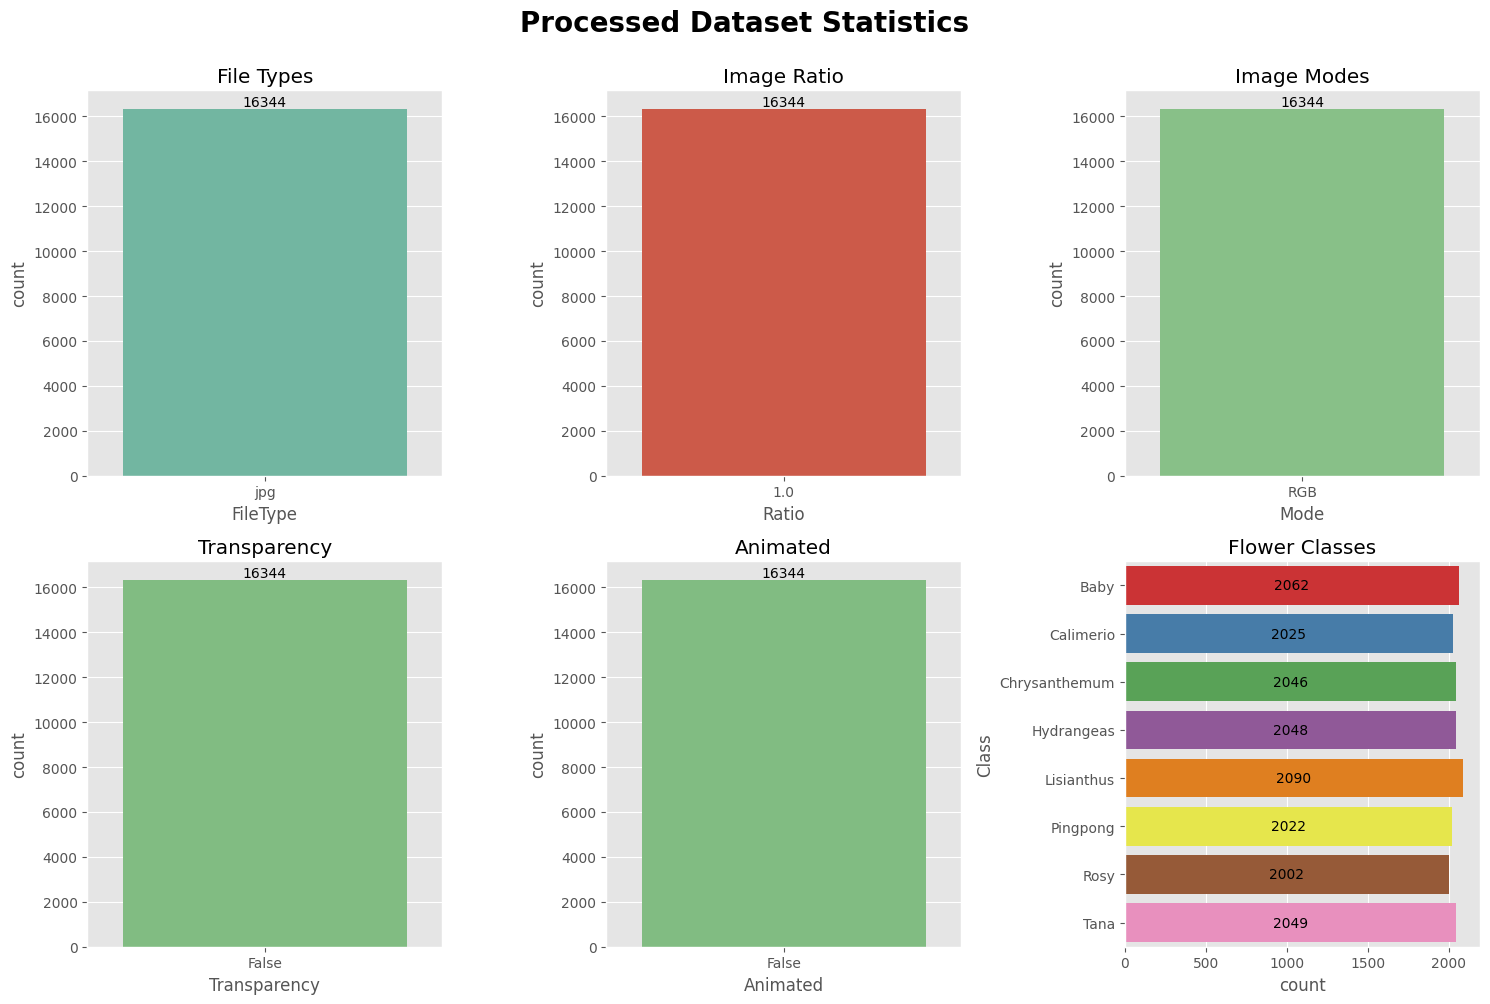

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

data_countplot(df_processed, 'FileType', ax=ax[0][0], title='File Types', annotate=True, palette='Set2')
data_countplot(df_processed, 'Ratio', ax=ax[0][1], title='Image Ratio', annotate=True)
data_countplot(df_processed, 'Mode', ax=ax[0][2], title='Image Modes', annotate=True, palette='Accent')
data_countplot(df_processed, 'Transparency', ax=ax[1][0], title='Transparency', annotate=True, palette='YlGn')
data_countplot(df_processed, 'Animated', ax=ax[1][1], title='Animated', annotate=True, palette='YlGn')
data_countplot(df_processed, 'Class', ax=ax[1][2], horizontal=True, title='Flower Classes', xticklabels_rotation=45, annotate=True, palette='Set1')

fig.suptitle('Processed Dataset Statistics', fontsize=20, fontweight='bold', y=1.0)
fig.tight_layout()

fig.savefig('images/DataPrep-ProcessedDataset-Stats.png')

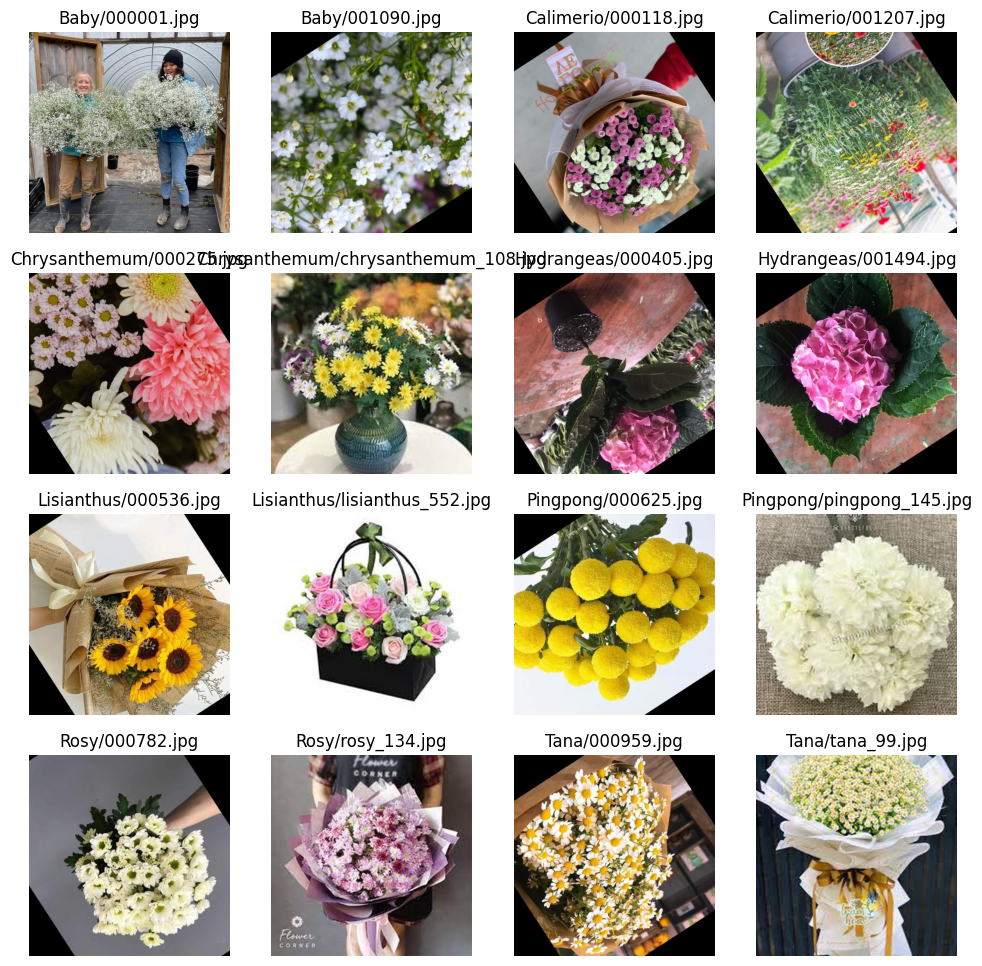

In [16]:
data_plot_16samples(path_processed_dataset, df_processed, to_file='images/DataPrep-ProcessedDataset-16Samples.png')

## 2.3. ☞ Final Observation

We have successfully cleaned and processed our dataset while minimally affecting our class distribution by using the techniques mentioned above. We also did not affect our dataset negatively in any other way. The processed data is stored in `./data/processed/`.

For further enhancement to our dataset in the future, we may try:

1. Remove Outliers:
    - Identify and remove outlier images that do not represent the desired classes or introduce noise into the dataset.
2. Noise Removal:
    - Apply noise removal techniques to clean up images with noise, artifacts, or irrelevant elements.

For now, we are not pursuing these due to our time constraint, since they are very time-consuming to implement (Remove Outliers) or not needed for our the image quality that we have (Noise Removal), and we are not sure if their effect on our models' performance is worth the time investment.